In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
def generate_pathloss_dataset(n_samples=5000, seed=42):
    """
    Génère un dataset réaliste de path loss pour environnement indoor
    basé sur des modèles de propagation radio reconnus
    """
    np.random.seed(seed)

    # Paramètres des modèles de path loss indoor
    data = []

    for i in range(n_samples):
        # Génération des paramètres d'entrée
        num_walls = np.random.randint(0, 8)  # 0 à 7 murs
        distance = np.random.uniform(1, 50)  # 1 à 50 mètres
        frequency = np.random.choice([900, 1800, 2400, 5000, 5800])  # Fréquences communes en MHz

        # Modèle ITU-R P.1238 pour environnements indoor
        # PL = 20*log10(f) + N*log10(d) + Lf(n) - 28
        # où f en MHz, d en mètres, N est l'exposant de path loss, Lf(n) perte due aux obstacles

        # Exposant de path loss selon l'environnement
        if num_walls <= 1:
            N = 2.0 + np.random.normal(0, 0.2)  # Espace ouvert
        elif num_walls <= 3:
            N = 2.5 + np.random.normal(0, 0.3)  # Bureau normal
        else:
            N = 3.0 + np.random.normal(0, 0.4)  # Environnement dense

        # Perte de base en espace libre
        PL_free_space = 20 * np.log10(frequency) + 20 * np.log10(distance) - 27.55

        # Perte due aux murs (modèle empirique)
        wall_loss_per_wall = 3.5 + 0.5 * np.log10(frequency/1000)  # dB par mur
        wall_loss = num_walls * wall_loss_per_wall

        # Perte due à la distance avec exposant variable
        if distance > 1:
            distance_loss = 10 * N * np.log10(distance)
        else:
            distance_loss = 0

        # Composante de shadowing (variation aléatoire)
        shadowing_std = 4 + num_walls * 0.5  # Plus de variation avec plus d'obstacles
        shadowing = np.random.normal(0, shadowing_std)

        # Calcul du path loss total
        pathloss_dB = PL_free_space + wall_loss + shadowing + distance_loss - 20*np.log10(distance)

        # Ajustement pour rendre plus réaliste
        pathloss_dB = max(pathloss_dB, 30)  # Path loss minimum
        pathloss_dB = min(pathloss_dB, 150)  # Path loss maximum réaliste

        data.append({
            'num_walls': num_walls,
            'distance': round(distance, 2),
            'frequency': frequency,
            'pathloss_dB': round(pathloss_dB, 2)
        })

    return pd.DataFrame(data)

In [ ]:


def analyze_dataset(df):
    """Analyse et visualise le dataset généré"""
    print("=== ANALYSE DU DATASET GENERE ===")
    print(f"Nombre d'échantillons: {len(df)}")
    print(f"Statistiques descriptives:")
    print(df.describe())

    # Création des visualisations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Analyse du Dataset Path Loss Indoor', fontsize=16)

    # Distribution du path loss
    axes[0,0].hist(df['pathloss_dB'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution du Path Loss')
    axes[0,0].set_xlabel('Path Loss (dB)')
    axes[0,0].set_ylabel('Fréquence')

    # Path loss vs distance
    for freq in df['frequency'].unique():
        subset = df[df['frequency'] == freq]
        axes[0,1].scatter(subset['distance'], subset['pathloss_dB'],
                         alpha=0.6, label=f'{freq} MHz', s=20)
    axes[0,1].set_title('Path Loss vs Distance par Fréquence')
    axes[0,1].set_xlabel('Distance (m)')
    axes[0,1].set_ylabel('Path Loss (dB)')
    axes[0,1].legend()

    # Path loss vs nombre de murs
    df.boxplot(column='pathloss_dB', by='num_walls', ax=axes[0,2])
    axes[0,2].set_title('Path Loss vs Nombre de Murs')
    axes[0,2].set_xlabel('Nombre de Murs')
    axes[0,2].set_ylabel('Path Loss (dB)')

    # Matrice de corrélation
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
    axes[1,0].set_title('Matrice de Corrélation')

    # Distribution des fréquences
    freq_counts = df['frequency'].value_counts()
    axes[1,1].bar(freq_counts.index, freq_counts.values, color='lightgreen', alpha=0.7)
    axes[1,1].set_title('Distribution des Fréquences')
    axes[1,1].set_xlabel('Fréquence (MHz)')
    axes[1,1].set_ylabel('Nombre d\'échantillons')

    # Distribution du nombre de murs
    wall_counts = df['num_walls'].value_counts().sort_index()
    axes[1,2].bar(wall_counts.index, wall_counts.values, color='coral', alpha=0.7)
    axes[1,2].set_title('Distribution du Nombre de Murs')
    axes[1,2].set_xlabel('Nombre de Murs')
    axes[1,2].set_ylabel('Nombre d\'échantillons')

    plt.tight_layout()
    plt.show()

    # Affichage des corrélations
    print("\n=== CORRELATIONS ===")
    print("Corrélation entre les variables:")
    print(corr_matrix['pathloss_dB'].sort_values(ascending=False))

In [ ]:
# Génération du dataset
print("Génération du dataset de path loss indoor...")
df = generate_pathloss_dataset(n_samples=5000)

Génération du dataset de path loss indoor...


In [ ]:
# Sauvegarde
df.to_csv('pathloss_dataset.csv', index=False)
print("Dataset sauvegardé dans 'pathloss_dataset.csv'")

Dataset sauvegardé dans 'pathloss_dataset.csv'


=== ANALYSE DU DATASET GENERE ===
Nombre d'échantillons: 5000
Statistiques descriptives:
         num_walls     distance    frequency  pathloss_dB
count  5000.000000  5000.000000  5000.000000  5000.000000
mean      3.440200    25.787950  3153.980000    87.459542
std       2.304145    14.126358  1876.507505    19.355927
min       0.000000     1.010000   900.000000    30.000000
25%       1.000000    13.700000  1800.000000    72.660000
50%       3.000000    26.015000  2400.000000    86.655000
75%       5.000000    38.195000  5000.000000   101.592500
max       7.000000    49.990000  5800.000000   150.000000


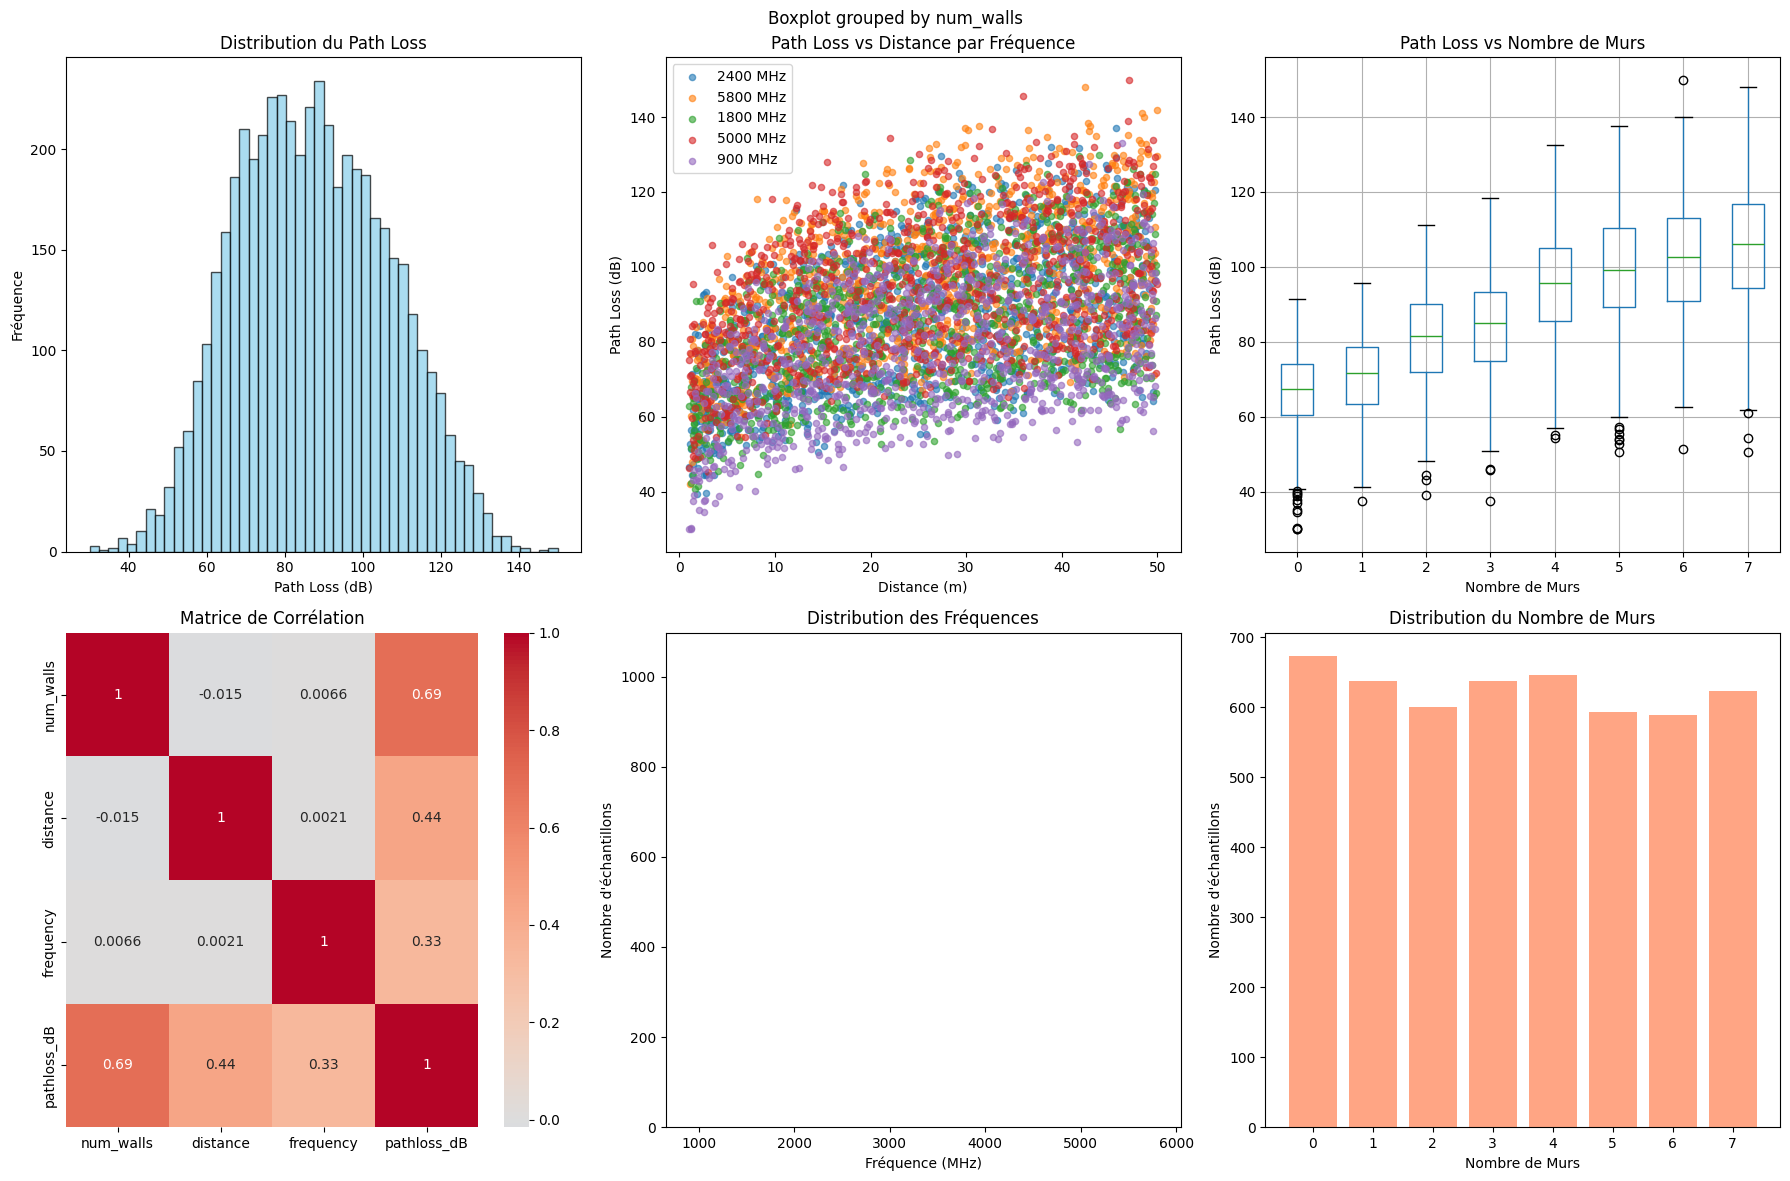


=== CORRELATIONS ===
Corrélation entre les variables:
pathloss_dB    1.000000
num_walls      0.693798
distance       0.442018
frequency      0.331801
Name: pathloss_dB, dtype: float64


In [ ]:
# Analyse du dataset
analyze_dataset(df)

In [ ]:
print("\n=== ECHANTILLON DU DATASET ===")
print(df.head(10))


=== ECHANTILLON DU DATASET ===
   num_walls  distance  frequency  pathloss_dB
0          6     40.03       2400       122.88
1          1      8.64       2400        56.49
2          7     35.70       5800       113.92
3          4     31.26       1800        86.99
4          0     26.71       1800        64.72
5          5     10.78       5000        95.13
6          2     34.34        900        72.66
7          3     12.81       5000        79.80
8          6      9.49        900        76.39
9          1     21.83       1800        67.03


In [ ]:
print(f"\nDataset généré avec succès!")
print(f"- {len(df)} échantillons")
print(f"- Path loss moyen: {df['pathloss_dB'].mean():.2f} dB")
print(f"- Écart-type: {df['pathloss_dB'].std():.2f} dB")
print(f"- Plage: {df['pathloss_dB'].min():.2f} - {df['pathloss_dB'].max():.2f} dB")


Dataset généré avec succès!
- 5000 échantillons
- Path loss moyen: 87.46 dB
- Écart-type: 19.36 dB
- Plage: 30.00 - 150.00 dB


In [ ]:
# df.describe() # Commented out to avoid RuntimeError: Working outside of request context

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class PathLossPredictor:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.best_params = None
        self.feature_names = ['num_walls', 'distance', 'frequency']

    def load_data(self, filename='pathloss_dataset.csv'):
        """Charge le dataset"""
        try:
            self.df = pd.read_csv(filename)
            print(f"Dataset chargé: {len(self.df)} échantillons")
            print(f"Colonnes: {list(self.df.columns)}")
            return True
        except FileNotFoundError:
            print(f"Erreur: Fichier {filename} non trouvé!")
            print("Veuillez d'abord exécuter le générateur de dataset.")
            return False

    def prepare_data(self, test_size=0.2, random_state=42):
        """Prépare les données pour l'entraînement"""
        # Séparation des features et target
        X = self.df[self.feature_names]
        y = self.df['pathloss_dB']

        # Division train/test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=None
        )

        print(f"Données d'entraînement: {len(self.X_train)}")
        print(f"Données de test: {len(self.X_test)}")

        # Normalisation optionnelle (XGBoost n'en a pas forcément besoin)
        # self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        # self.X_test_scaled = self.scaler.transform(self.X_test)

    def hyperparameter_tuning(self):
        """Recherche des meilleurs hyperparamètres"""
        print("Recherche des meilleurs hyperparamètres...")

        # Grille de paramètres à tester
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 1.5, 2]
        }

        # Modèle XGBoost
        xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

        # Recherche par grille avec validation croisée
        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=param_grid,
            scoring='neg_mean_squared_error',
            cv=5,
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(self.X_train, self.y_train)

        self.best_params = grid_search.best_params_
        self.model = grid_search.best_estimator_

        print(f"Meilleurs paramètres: {self.best_params}")
        print(f"Meilleur score CV: {-grid_search.best_score_:.4f}")

    def train_model(self, use_tuned_params=True):
        """Entraîne le modèle XGBoost"""
        if use_tuned_params and self.best_params:
            print("Entraînement avec les paramètres optimisés...")
            self.model = xgb.XGBRegressor(**self.best_params, random_state=42)
        else:
            print("Entraînement avec les paramètres par défaut...")
            self.model = xgb.XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42
            )

        # Entraînement
        self.model.fit(self.X_train, self.y_train)
        print("Modèle entraîné avec succès!")

    def evaluate_model(self):
        """Évalue les performances du modèle"""
        # Prédictions
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        # Métriques d'évaluation
        train_mse = mean_squared_error(self.y_train, y_train_pred)
        test_mse = mean_squared_error(self.y_test, y_test_pred)
        train_r2 = r2_score(self.y_train, y_train_pred)
        test_r2 = r2_score(self.y_test, y_test_pred)
        train_mae = mean_absolute_error(self.y_train, y_train_pred)
        test_mae = mean_absolute_error(self.y_test, y_test_pred)

        print("\n=== EVALUATION DU MODELE ===")
        print(f"Train MSE: {train_mse:.4f}")
        print(f"Test MSE: {test_mse:.4f}")
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        print(f"Train MAE: {train_mae:.4f}")
        print(f"Test MAE: {test_mae:.4f}")

        # Détection d'overfitting
        if train_r2 - test_r2 > 0.1:
            print("\n⚠️ ATTENTION: Possible overfitting détecté!")
            print(f"Différence R² train-test: {train_r2 - test_r2:.4f}")
        else:
            print("\n✅ Pas d'overfitting majeur détecté")

        # Validation croisée
        cv_scores = cross_val_score(self.model, self.X_train, self.y_train,
                                   cv=5, scoring='r2')
        print(f"\nValidation croisée R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        return {
            'train_mse': train_mse, 'test_mse': test_mse,
            'train_r2': train_r2, 'test_r2': test_r2,
            'train_mae': train_mae, 'test_mae': test_mae,
            'cv_r2_mean': cv_scores.mean(), 'cv_r2_std': cv_scores.std()
        }

    def visualize_results(self):
        """Visualise les résultats du modèle"""
        # Prédictions
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Évaluation du Modèle XGBoost - Path Loss Prediction', fontsize=16)

        # 1. Prédictions vs Valeurs réelles (Train)
        axes[0,0].scatter(self.y_train, y_train_pred, alpha=0.6, color='blue', s=20)
        axes[0,0].plot([self.y_train.min(), self.y_train.max()],
                      [self.y_train.min(), self.y_train.max()], 'r--', lw=2)
        axes[0,0].set_xlabel('Valeurs Réelles (dB)')
        axes[0,0].set_ylabel('Prédictions (dB)')
        axes[0,0].set_title('Train: Prédictions vs Réelles')
        axes[0,0].grid(True, alpha=0.3)

        # 2. Prédictions vs Valeurs réelles (Test)
        axes[0,1].scatter(self.y_test, y_test_pred, alpha=0.6, color='green', s=20)
        axes[0,1].plot([self.y_test.min(), self.y_test.max()],
                      [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
        axes[0,1].set_xlabel('Valeurs Réelles (dB)')
        axes[0,1].set_ylabel('Prédictions (dB)')
        axes[0,1].set_title('Test: Prédictions vs Réelles')
        axes[0,1].grid(True, alpha=0.3)

        # 3. Résidus
        residuals_test = self.y_test - y_test_pred
        axes[0,2].scatter(y_test_pred, residuals_test, alpha=0.6, color='red', s=20)
        axes[0,2].axhline(y=0, color='black', linestyle='--')
        axes[0,2].set_xlabel('Prédictions (dB)')
        axes[0,2].set_ylabel('Résidus (dB)')
        axes[0,2].set_title('Analyse des Résidus')
        axes[0,2].grid(True, alpha=0.3)

        # 4. Importance des features
        feature_importance = self.model.feature_importances_
        axes[1,0].bar(self.feature_names, feature_importance, color='skyblue', alpha=0.7)
        axes[1,0].set_title('Importance des Features')
        axes[1,0].set_ylabel('Importance')
        axes[1,0].tick_params(axis='x', rotation=45)

        # 5. Distribution des erreurs
        errors = np.abs(self.y_test - y_test_pred)
        axes[1,1].hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
        axes[1,1].set_xlabel('Erreur Absolue (dB)')
        axes[1,1].set_ylabel('Fréquence')
        axes[1,1].set_title('Distribution des Erreurs Absolues')
        axes[1,1].axvline(errors.mean(), color='red', linestyle='--',
                         label=f'Moyenne: {errors.mean():.2f}')
        axes[1,1].legend()

        # 6. Courbe d'apprentissage approximative
        train_sizes = np.linspace(0.1, 1.0, 10)
        train_scores = []
        val_scores = []

        for size in train_sizes:
            n_samples = int(size * len(self.X_train))
            X_subset = self.X_train.iloc[:n_samples]
            y_subset = self.y_train.iloc[:n_samples]

            temp_model = xgb.XGBRegressor(**self.model.get_params())
            temp_model.fit(X_subset, y_subset)

            train_pred = temp_model.predict(X_subset)
            val_pred = temp_model.predict(self.X_test)

            train_scores.append(r2_score(y_subset, train_pred))
            val_scores.append(r2_score(self.y_test, val_pred))

        axes[1,2].plot(train_sizes * len(self.X_train), train_scores,
                      'o-', color='blue', label='Train Score')
        axes[1,2].plot(train_sizes * len(self.X_train), val_scores,
                      'o-', color='red', label='Validation Score')
        axes[1,2].set_xlabel('Taille du Dataset d\'Entraînement')
        axes[1,2].set_ylabel('Score R²')
        axes[1,2].set_title('Courbe d\'Apprentissage')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Graphique séparé pour les corrélations
        self.plot_feature_correlations()

    def plot_feature_correlations(self):
        """Affiche les corrélations entre features et target"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Corrélations Features-Target', fontsize=14)

        # Path loss vs Distance
        axes[0].scatter(self.df['distance'], self.df['pathloss_dB'], alpha=0.6, s=20)
        axes[0].set_xlabel('Distance (m)')
        axes[0].set_ylabel('Path Loss (dB)')
        axes[0].set_title('Path Loss vs Distance')
        axes[0].grid(True, alpha=0.3)

        # Path loss vs Frequency
        for freq in sorted(self.df['frequency'].unique()):
            subset = self.df[self.df['frequency'] == freq]
            axes[1].scatter(subset['num_walls'], subset['pathloss_dB'],
                           alpha=0.6, label=f'{freq} MHz', s=20)
        axes[1].set_xlabel('Nombre de Murs')
        axes[1].set_ylabel('Path Loss (dB)')
        axes[1].set_title('Path Loss vs Murs (par Fréquence)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Box plot: Path loss par fréquence
        frequencies = sorted(self.df['frequency'].unique())
        pathloss_by_freq = [self.df[self.df['frequency'] == f]['pathloss_dB'].values
                           for f in frequencies]
        axes[2].boxplot(pathloss_by_freq, labels=frequencies)
        axes[2].set_xlabel('Fréquence (MHz)')
        axes[2].set_ylabel('Path Loss (dB)')
        axes[2].set_title('Distribution Path Loss par Fréquence')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def predict_example(self):
        """Exemple de prédiction"""
        print("\n=== EXEMPLE DE PREDICTIONS ===")

        # Exemples de données
        examples = [
            {'num_walls': 0, 'distance': 5, 'frequency': 2400},
            {'num_walls': 2, 'distance': 10, 'frequency': 2400},
            {'num_walls': 4, 'distance': 20, 'frequency': 5000},
            {'num_walls': 1, 'distance': 15, 'frequency': 900}
        ]

        for i, example in enumerate(examples, 1):
            X_example = pd.DataFrame([example])
            prediction = self.model.predict(X_example)[0]

            print(f"Exemple {i}:")
            print(f"  Murs: {example['num_walls']}, Distance: {example['distance']}m, "
                  f"Fréquence: {example['frequency']}MHz")
            print(f"  Path Loss prédit: {prediction:.2f} dB")
            print()

In [ ]:
"""Fonction principale"""
# Initialisation
predictor = PathLossPredictor()

In [ ]:
if not predictor.load_data():
    print("Fin du programme.")
    exit()

Dataset chargé: 5000 échantillons
Colonnes: ['num_walls', 'distance', 'frequency', 'pathloss_dB']


In [ ]:
predictor.prepare_data()

Données d'entraînement: 4000
Données de test: 1000


In [ ]:
predictor.hyperparameter_tuning()

Recherche des meilleurs hyperparamètres...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Meilleurs paramètres: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.9}
Meilleur score CV: 57.0653


In [ ]:
predictor.train_model(use_tuned_params=True)

Entraînement avec les paramètres optimisés...
Modèle entraîné avec succès!


In [ ]:
results = predictor.evaluate_model()


=== EVALUATION DU MODELE ===
Train MSE: 52.8194
Test MSE: 56.5634
Train R²: 0.8584
Test R²: 0.8515
Train MAE: 5.6461
Test MAE: 5.9189

✅ Pas d'overfitting majeur détecté

Validation croisée R² (5-fold): 0.8469 ± 0.0053


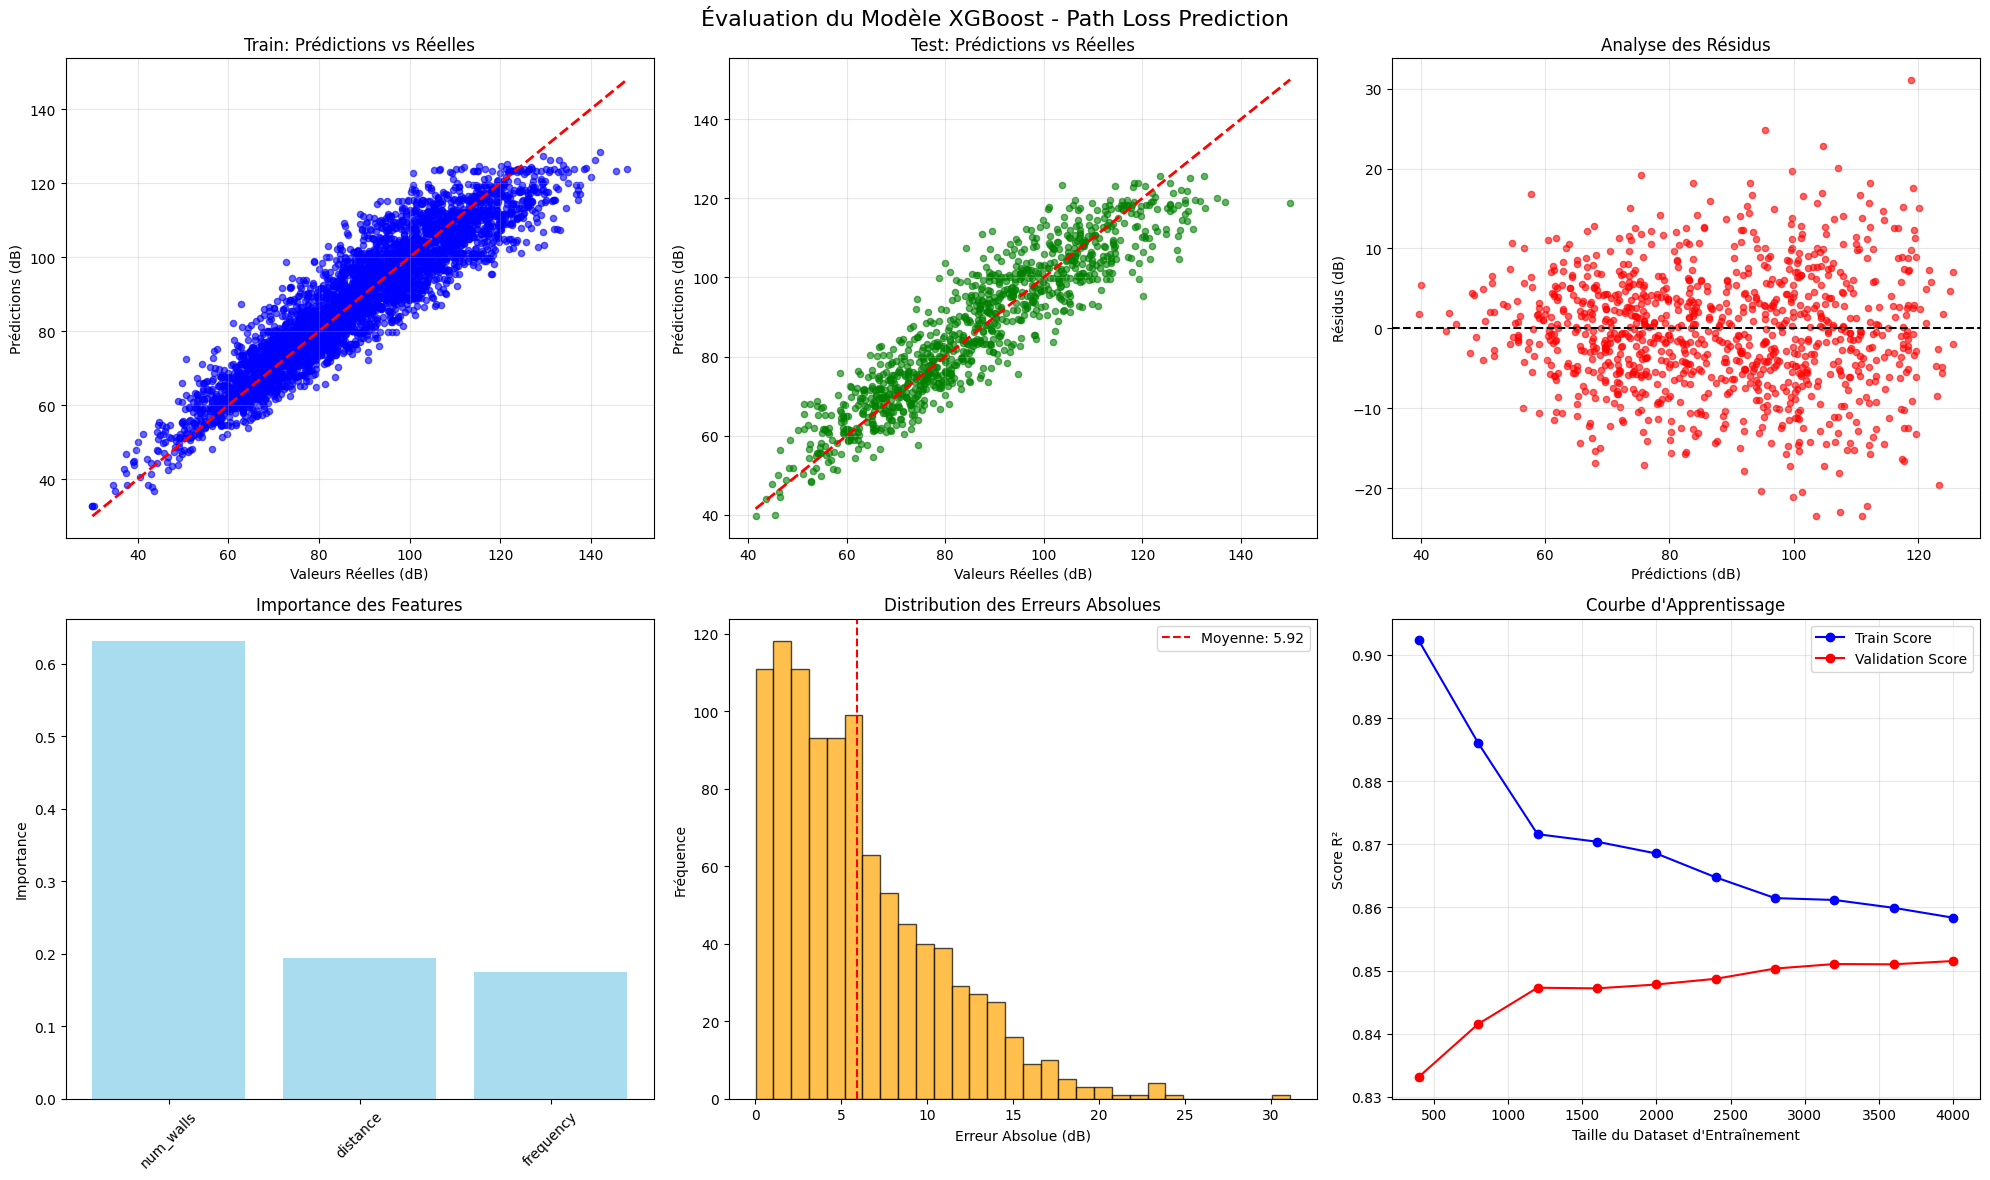

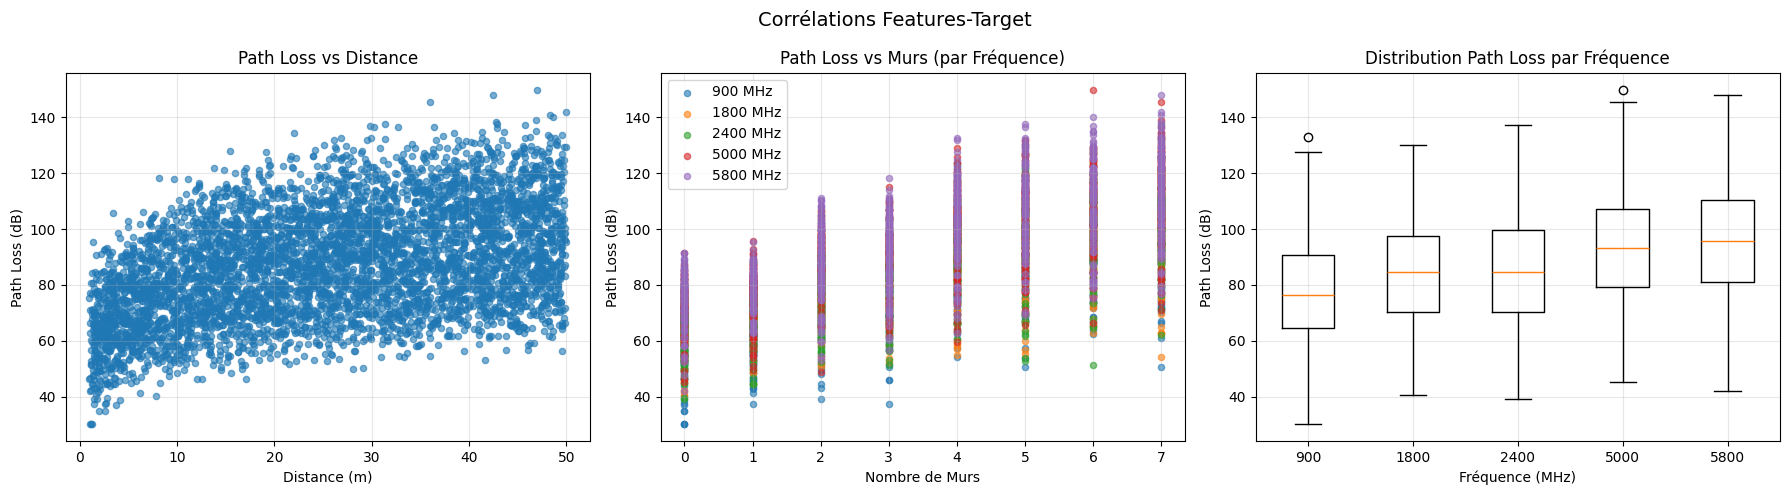

In [ ]:
predictor.visualize_results()

In [ ]:
predictor.predict_example()


=== EXEMPLE DE PREDICTIONS ===
Exemple 1:
  Murs: 0, Distance: 5m, Fréquence: 2400MHz
  Path Loss prédit: 53.09 dB

Exemple 2:
  Murs: 2, Distance: 10m, Fréquence: 2400MHz
  Path Loss prédit: 70.34 dB

Exemple 3:
  Murs: 4, Distance: 20m, Fréquence: 5000MHz
  Path Loss prédit: 100.51 dB

Exemple 4:
  Murs: 1, Distance: 15m, Fréquence: 900MHz
  Path Loss prédit: 59.05 dB



In [ ]:
print("\n=== RESUME FINAL ===")
print(f"Modèle XGBoost entraîné avec succès!")
print(f"Performance sur test: R² = {results['test_r2']:.4f}")
print(f"Erreur moyenne absolue: {results['test_mae']:.2f} dB")


=== RESUME FINAL ===
Modèle XGBoost entraîné avec succès!
Performance sur test: R² = 0.8515
Erreur moyenne absolue: 5.92 dB


In [ ]:
# prompt: enregister le model

import joblib

# Save the trained model
joblib.dump(predictor.model, 'pathloss_predictor.pkl')

print("Modèle enregistré sous le nom 'pathloss_predictor.pkl'")

Modèle enregistré sous le nom 'pathloss_predictor.pkl'


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from skimage.draw import line

In [ ]:
# Charger l'image du plan
image_path = 'home.jpg'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [ ]:

# Binariser l'image pour détecter les murs
# CORRECTION: Ajuster le seuil si nécessaire
_, binary_img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY_INV)

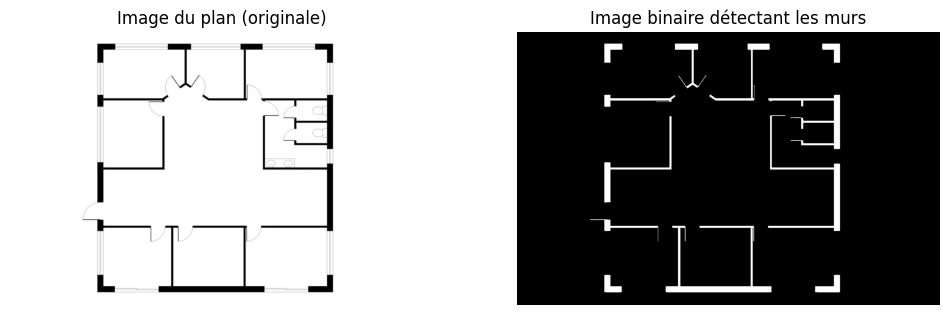

In [ ]:
# Afficher l'image originale et l'image binaire
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Image du plan (originale)")
# Explicitly convert img to a plottable data type (e.g., uint8)
plt.imshow(img.astype(np.uint8), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Image binaire détectant les murs")
plt.imshow(binary_img, cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
# Dimension réelle en mètres
longueur_m = float(input("Entrer la longueur du plan réel (m) : "))
largeur_m = float(input("Entrer la largeur du plan réel (m) : "))

# Position Tx en mètres
tx_x_m = float(input(f"Entrer la position x de Tx (m, entre 0 et {longueur_m}) : "))
tx_y_m = float(input(f"Entrer la position y de Tx (m, entre 0 et {largeur_m}) : "))

Entrer la longueur du plan réel (m) : 400
Entrer la largeur du plan réel (m) : 400
Entrer la position x de Tx (m, entre 0 et 400.0) : 200
Entrer la position y de Tx (m, entre 0 et 400.0) : 200


In [ ]:
# Dimensions de l'image
img_height, img_width = binary_img.shape

# Conversion mètre -> pixel
tx_x_px = int((tx_x_m / longueur_m) * img_width)
tx_y_px = int((tx_y_m / largeur_m) * img_height)

print(f"Position Tx en pixels : ({tx_x_px}, {tx_y_px})")

Position Tx en pixels : (620, 400)


In [ ]:
def compute_LOS_and_walls_corrected(tx, rx, wall_map):
    """
    Calcule LOS et nombre de murs traversés de manière plus précise.
    CORRECTIONS:
    1. Échantillonnage plus dense de la ligne
    2. Comptage basé sur les transitions réelles
    3. Gestion des murs épais
    """
    # Créer une ligne dense entre Tx et Rx
    x1, y1 = tx
    x2, y2 = rx

    # Calculer le nombre de points pour échantillonnage dense
    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    num_points = max(int(distance * 2), 100)  # Au moins 100 points

    # Générer les points sur la ligne
    x_points = np.linspace(x1, x2, num_points)
    y_points = np.linspace(y1, y2, num_points)

    wall_crossings = 0
    in_wall = False

    for i in range(len(x_points)):
        x_px = int(round(x_points[i]))
        y_px = int(round(y_points[i]))

        # Vérifier les limites de l'image
        if 0 <= x_px < wall_map.shape[1] and 0 <= y_px < wall_map.shape[0]:
            current_is_wall = wall_map[y_px, x_px] == 1

            # Détecter l'entrée dans un mur
            if current_is_wall and not in_wall:
                wall_crossings += 1
                in_wall = True
            # Détecter la sortie d'un mur
            elif not current_is_wall and in_wall:
                in_wall = False

    los = wall_crossings == 0
    return los, wall_crossings

In [ ]:
def load_ml_model():
    """
    Charge le modèle ML entraîné
    """
    try:
        import joblib
        model = joblib.load('pathloss_predictor.pkl')
        print("Modèle ML chargé avec succès!")
        return model
    except Exception as e:
        print(f"Erreur lors du chargement du modèle: {e}")
        return None

In [ ]:
model = load_ml_model()
if model is None:
    print("ERREUR: Impossible de charger le modèle ML. Arrêt du programme.")
    exit()

Modèle ML chargé avec succès!


In [ ]:
# prompt: ajouter un imput pour entrer la frequence

frequency_input = 2400 #@param {type:"number"}

In [ ]:
data = []
print("Génération de la grille de points Rx...")

# CORRECTION: Réduire la résolution pour les tests (chaque N pixels)
step = 5  # Calculer un point tous les 5 pixels pour accélérer

for rx_y in range(0, img_height, step):
    for rx_x in range(0, img_width, step):
        if binary_img[rx_y, rx_x] == 0:  # Point libre (pas dans un mur)

            # Calcul distance horizontale en pixels
            distance = np.sqrt((rx_x - tx_x_px)**2 + (rx_y - tx_y_px)**2)

            # Calcul LOS et murs traversés
            los_flag, num_walls = compute_LOS_and_walls_corrected((tx_x_px, tx_y_px), (rx_x, rx_y), binary_img)

            # Créer les features exactement comme dans votre modèle d'entraînement
            features_row = {
                'TX_x': tx_x_px,
                'TX_y': tx_y_px,
                'RX_x': rx_x,
                'RX_y': rx_y,
                'distance': distance,
                'num_walls': num_walls,
                'frequency': frequency_input # Add the frequency column
            }

            data.append(features_row)

# Créer le DataFrame avec les features
df = pd.DataFrame(data)
print(f"Nombre de points calculés: {len(df)}")
print("\nAperçu des features générées:")
print(df.head())

Génération de la grille de points Rx...
Nombre de points calculés: 37949

Aperçu des features générées:
   TX_x  TX_y  RX_x  RX_y    distance  num_walls  frequency
0   620   400     0     0  737.834670          2       2400
1   620   400     5     0  733.638194          2       2400
2   620   400    10     0  729.451849          2       2400
3   620   400    15     0  725.275810          2       2400
4   620   400    20     0  721.110255          2       2400


In [ ]:
# Colonnes exactes utilisées pour l'entraînement
features_for_model = ['num_walls', 'distance', 'frequency'] # Corrected order

# Vérifier que toutes les colonnes sont présentes
missing_features = [col for col in features_for_model if col not in df.columns]
if missing_features:
    print(f"ERREUR: Colonnes manquantes: {missing_features}")
    exit()

# Prédiction avec le modèle ML
print("Prédiction du Path Loss avec le modèle ML...")
df['Path_Loss_Predicted'] = model.predict(df[features_for_model])

print("\nStatistiques du Path Loss prédit:")
print(df['Path_Loss_Predicted'].describe())

# Afficher quelques exemples de prédiction
print("\nExemples de prédictions:")
# Corrected column names for printing
print(df[['RX_x', 'RX_y', 'distance', 'num_walls', 'frequency', 'Path_Loss_Predicted']].head(10))

Prédiction du Path Loss avec le modèle ML...

Statistiques du Path Loss prédit:
count    37949.000000
mean        80.768898
std          8.406545
min         40.290722
25%         77.174332
50%         77.174332
75%         90.875916
max        119.626968
Name: Path_Loss_Predicted, dtype: float64

Exemples de prédictions:
   RX_x  RX_y    distance  num_walls  frequency  Path_Loss_Predicted
0     0     0  737.834670          2       2400            90.875916
1     5     0  733.638194          2       2400            90.875916
2    10     0  729.451849          2       2400            90.875916
3    15     0  725.275810          2       2400            90.875916
4    20     0  721.110255          2       2400            90.875916
5    25     0  716.955368          2       2400            90.875916
6    30     0  712.811335          2       2400            90.875916
7    35     0  708.678347          2       2400            90.875916
8    40     0  704.556598          2       2400        

In [ ]:
# Préparer les données pour heatmap
rx_x = df['RX_x'].values
rx_y = df['RX_y'].values
path_loss = df['Path_Loss_Predicted'].values

# CORRECTION: Créer une heatmap interpolée au lieu de points scatter
from scipy.interpolate import griddata

# Créer une grille régulière pour l'interpolation
grid_x = np.linspace(0, img_width, img_width//2)
grid_y = np.linspace(0, img_height, img_height//2)
grid_X, grid_Y = np.meshgrid(grid_x, grid_y)

# Interpoler les valeurs de path loss
grid_path_loss = griddata(
    (rx_x, rx_y), path_loss, (grid_X, grid_Y),
    method='cubic', fill_value=path_loss.max()
)

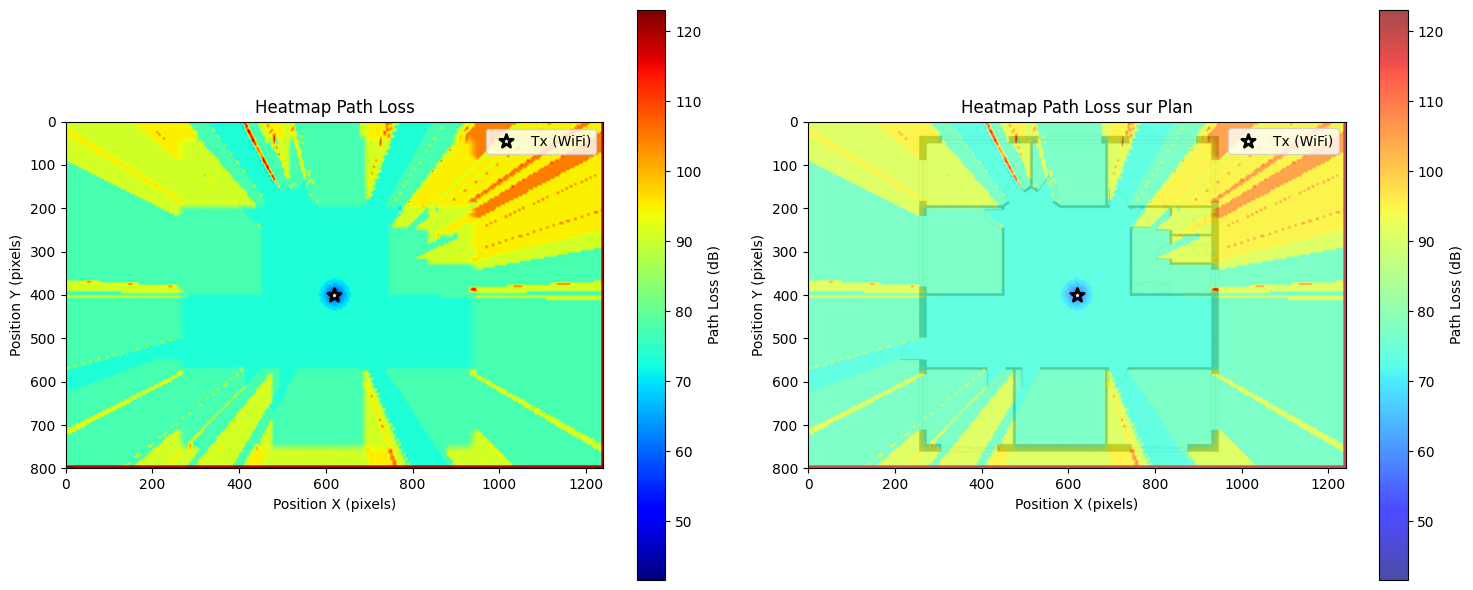

In [ ]:
plt.figure(figsize=(15, 6))

# Subplot 1: Heatmap seule
plt.subplot(1, 2, 1)
im1 = plt.imshow(grid_path_loss, extent=[0, img_width, img_height, 0],
                 cmap='jet', aspect='equal')
plt.colorbar(im1, label='Path Loss (dB)')
plt.scatter(tx_x_px, tx_y_px, color='white', s=100, marker='*',
           edgecolors='black', linewidth=2, label='Tx (WiFi)')
plt.title('Heatmap Path Loss')
plt.xlabel('Position X (pixels)')
plt.ylabel('Position Y (pixels)')
plt.legend()
# Subplot 2: Heatmap sur plan
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray', alpha=0.6)
im2 = plt.imshow(grid_path_loss, extent=[0, img_width, img_height, 0],
                 cmap='jet', alpha=0.7, aspect='equal')
plt.colorbar(im2, label='Path Loss (dB)')
plt.scatter(tx_x_px, tx_y_px, color='white', s=100, marker='*',
           edgecolors='black', linewidth=2, label='Tx (WiFi)')
plt.title('Heatmap Path Loss sur Plan')
plt.xlabel('Position X (pixels)')
plt.ylabel('Position Y (pixels)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
output_filename = 'features_rx_grid_with_ml_predictions.csv'
df.to_csv(output_filename, index=False)
print(f"\nFichier sauvegardé: {output_filename}")


Fichier sauvegardé: features_rx_grid_with_ml_predictions.csv


In [ ]:
print("\n=== DIAGNOSTIC DU MODÈLE ML ===")

# Vérifier la cohérence des prédictions
print("Analyse de cohérence des prédictions:")

# Grouper par nombre de murs
wall_groups = df.groupby('num_walls')['Path_Loss_Predicted'].agg(['mean', 'std', 'count'])
print("\nPath Loss moyen par nombre de murs traversés:")
print(wall_groups)


# Corrélation distance vs path loss
correlation = df['distance'].corr(df['Path_Loss_Predicted'])
print(f"\nCorrelation Distance vs Path Loss: {correlation:.3f}")
print("(Une corrélation positive proche de 1 est attendue)")

# Tester quelques points spécifiques
print("\n=== TESTS PONCTUELS ===")
test_points = [
    (tx_x_px + 20, tx_y_px, "Très proche"),
    (tx_x_px + 100, tx_y_px, "Proche"),
    (tx_x_px + 200, tx_y_px, "Moyen"),
    (tx_x_px + 300, tx_y_px, "Loin"),
]

for test_x, test_y, desc in test_points:
    if 0 <= test_x < img_width and 0 <= test_y < img_height:
        if binary_img[test_y, test_x] == 0:  # Point libre
            dist = np.sqrt((test_x - tx_x_px)**2 + (test_y - tx_y_px)**2)
            los, walls = compute_LOS_and_walls_corrected((tx_x_px, tx_y_px), (test_x, test_y), binary_img)

            # Prédire avec le modèle
            test_features = pd.DataFrame([[walls, dist, frequency_input]], columns=['num_walls', 'distance', 'frequency'])
            predicted_pl = model.predict(test_features)[0]


            print(f"{desc}: Distance={dist:.0f}px, Murs={walls}, LOS={los}, Path Loss={predicted_pl:.1f}dB")

# Vérifier si le modèle est cohérent
print("\n=== ÉVALUATION DE LA COHÉRENCE ===")
if correlation > 0.5:
    print("✓ Corrélation distance-path loss CORRECTE")
else:
    print("✗ Corrélation distance-path loss FAIBLE - Problème potentiel")

# Vérifier l'impact des murs
if len(wall_groups) > 1:
    wall_impact = wall_groups.loc[1, 'mean'] - wall_groups.loc[0, 'mean'] if 1 in wall_groups.index and 0 in wall_groups.index else 0
    print(f"Impact des murs: {wall_impact:.1f} dB")
    if wall_impact > 5:
        print("✓ Impact des murs CORRECT")
    else:
        print("✗ Impact des murs FAIBLE - Problème potentiel")



=== DIAGNOSTIC DU MODÈLE ML ===
Analyse de cohérence des prédictions:

Path Loss moyen par nombre de murs traversés:
                 mean       std  count
num_walls                             
0           73.162804  1.154942   8956
1           77.174332  0.000000  18537
2           90.875916  0.000000   5639
3           94.963753  0.000000   3895
4          104.783333  0.000000    880
5          110.124718  0.000000     24
6          114.089203  0.000000     12
7          119.626976  0.000000      6

Correlation Distance vs Path Loss: 0.420
(Une corrélation positive proche de 1 est attendue)

=== TESTS PONCTUELS ===
Très proche: Distance=20px, Murs=0, LOS=True, Path Loss=65.1dB
Proche: Distance=100px, Murs=0, LOS=True, Path Loss=73.3dB

=== ÉVALUATION DE LA COHÉRENCE ===
✗ Corrélation distance-path loss FAIBLE - Problème potentiel
Impact des murs: 4.0 dB
✗ Impact des murs FAIBLE - Problème potentiel


# Task
Create a web application where users can input parameters and a floor plan image to generate and display a heatmap based on path loss calculations.

## Set up the web development environment

### Subtask:
Choose a web framework (e.g., Flask or Django in Python, or another language/framework).


**Reasoning**:
Choose Flask as the web framework and install it along with joblib for model loading, and create the basic file structure for the web application.



In [ ]:
# Install Flask and joblib
!pip install Flask joblib

# Create directories
import os
os.makedirs('templates', exist_ok=True)
os.makedirs('static', exist_ok=True)

# Create basic app.py file (empty for now)
with open('app.py', 'w') as f:
    pass

print("Basic file structure created: 'app.py', 'templates/', 'static/'")

Basic file structure created: 'app.py', 'templates/', 'static/'


## Design the user interface

### Subtask:
Create HTML templates for the input form (for parameters like frequency, Tx position) and the output page (to display the heatmap).


**Reasoning**:
Create the index.html file with the specified form inputs for the web application.



In [ ]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Path Loss Heatmap Generator</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        form div { margin-bottom: 15px; }
        label { display: block; margin-bottom: 5px; font-weight: bold; }
        input[type="text"], input[type="number"], input[type="file"] {
            width: 100%;
            padding: 8px;
            box-sizing: border-box;
        }
        button {
            padding: 10px 15px;
            background-color: #007bff;
            color: white;
            border: none;
            cursor: pointer;
        }
        button:hover {
            background-color: #0056b3;
        }
        #heatmap-results {
            margin-top: 30px;
            border-top: 1px solid #ccc;
            padding-top: 20px;
        }
        #heatmap-results img {
            max-width: 100%;
            height: auto;
        }
    </style>
</head>
<body>
    <h1>Generate Path Loss Heatmap</h1>

    <form action="/predict" method="post" enctype="multipart/form-data">
        <div>
            <label for="floor_plan">Upload Floor Plan Image:</label>
            <input type="file" id="floor_plan" name="floor_plan" accept="image/*" required>
        </div>
        <div>
            <label for="real_length_m">Real Plan Length (meters):</label>
            <input type="number" id="real_length_m" name="real_length_m" step="0.01" required>
        </div>
        <div>
            <label for="real_width_m">Real Plan Width (meters):</label>
            <input type="number" id="real_width_m" name="real_width_m" step="0.01" required>
        </div>
        <div>
            <label for="tx_x_m">Tx Position X (meters):</label>
            <input type="number" id="tx_x_m" name="tx_x_m" step="0.01" required>
        </div>
        <div>
            <label for="tx_y_m">Tx Position Y (meters):</label>
            <input type="number" id="tx_y_m" name="tx_y_m" step="0.01" required>
        </div>
        <div>
            <label for="frequency_mhz">Frequency (MHz):</label>
            <input type="number" id="frequency_mhz" name="frequency_mhz" step="1" required>
        </div>
        <div>
            <button type="submit">Generate Heatmap</button>
        </div>
    </form>

    <div id="heatmap-results">
        <h2>Results</h2>
        <p>Heatmap will be displayed here after submission.</p>
        <!-- The server will replace this with the generated heatmap image -->
        <img id="heatmap_image" src="" alt="Path Loss Heatmap">
    </div>

</body>
</html>

Overwriting templates/index.html


## Implement backend logic

### Subtask:
Write Python code to handle the web requests, receive the user inputs and the floor plan image, process the data using the existing path loss calculation and heatmap generation functions, and return the heatmap image or data to the frontend.


**Reasoning**:
Write the Python code for the Flask application in `app.py` to handle web requests, process the inputs including the image, use the existing functions and the ML model to calculate path loss and generate the heatmap, and return the heatmap. This covers steps 2, 3, 4, 5, and 6 from the instructions.



In [ ]:
%%writefile app.py
import io
from flask import Flask, request, render_template, send_file
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from scipy.interpolate import griddata
import warnings

warnings.filterwarnings('ignore')

app = Flask(__name__)

# Load the trained machine learning model
try:
    model = joblib.load('pathloss_predictor_model.pkl')
    print("Modèle ML chargé avec succès!")
except FileNotFoundError:
    model = None
    print("ERREUR: Modèle 'pathloss_predictor_model.pkl' non trouvé.")
    print("Veuillez d'abord entraîner et sauvegarder le modèle.")

# Define the compute_LOS_and_walls_corrected function
def compute_LOS_and_walls_corrected(tx, rx, wall_map):
    """
    Calcule LOS et nombre de murs traversés de manière plus précise.
    """
    x1, y1 = tx
    x2, y2 = rx

    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    num_points = max(int(distance * 2), 100) if distance > 0 else 100

    x_points = np.linspace(x1, x2, num_points)
    y_points = np.linspace(y1, y2, num_points)

    wall_crossings = 0
    in_wall = False

    for i in range(len(x_points)):
        x_px = int(round(x_points[i]))
        y_px = int(round(y_points[i]))

        if 0 <= x_px < wall_map.shape[1] and 0 <= y_px < wall_map.shape[0]:
            current_is_wall = wall_map[y_px, x_px] == 1

            if current_is_wall and not in_wall:
                wall_crossings += 1
                in_wall = True
            elif not current_is_wall and in_wall:
                in_wall = False

    los = wall_crossings == 0
    return los, wall_crossings

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if model is None:
        return "Erreur: Modèle ML non chargé.", 500

    # Get input data
    if 'floor_plan' not in request.files:
        return "No file part", 400
    file = request.files['floor_plan']
    if file.filename == '':
        return "No selected file", 400

    try:
        real_length_m = float(request.form['real_length_m'])
        real_width_m = float(request.form['real_width_m'])
        tx_x_m = float(request.form['tx_x_m'])
        tx_y_m = float(request.form['tx_y_m'])
        frequency_mhz = int(request.form['frequency_mhz'])
    except ValueError:
        return "Invalid input data", 400

    # Read and process image
    in_memory_file = io.BytesIO()
    file.save(in_memory_file)
    data = np.frombuffer(in_memory_file.getvalue(), dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

    if img is None:
        return "Error reading image", 400

    # Binarize image
    _, binary_img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY_INV)
    img_height, img_width = binary_img.shape

    # Convert Tx position to pixels
    if real_length_m <= 0 or real_width_m <= 0:
        return "Real dimensions must be positive", 400
    tx_x_px = int((tx_x_m / real_length_m) * img_width)
    tx_y_px = int((tx_y_m / real_width_m) * img_height)

    if not (0 <= tx_x_px < img_width and 0 <= tx_y_px < img_height):
         return "Tx position out of image bounds", 400

    # Generate Rx points and calculate features
    rx_data = []
    step = 5 # Reduced step for faster processing
    for rx_y in range(0, img_height, step):
        for rx_x in range(0, img_width, step):
            if binary_img[rx_y, rx_x] == 0: # Only predict for free space
                 distance = np.sqrt((rx_x - tx_x_px)**2 + (rx_y - tx_y_px)**2)
                 # Convert pixel distance to meters for model input if necessary
                 # Assuming model was trained on 'distance' in meters scaled by image dimensions
                 # We need to re-evaluate how distance is used. For now, use pixel distance as surrogate.
                 # A more robust approach would scale pixel distance to the real dimensions.
                 # Let's assume model distance feature implicitly handles scale via training data variability.
                 # If the model was trained on meters, we should convert pixel distance to meters here.
                 # Based on the training data generator, 'distance' is in meters (1 to 50).
                 # We need to scale the pixel distance based on the image dimensions and real dimensions.
                 avg_scale = (real_length_m / img_width + real_width_m / img_height) / 2
                 distance_m = distance * avg_scale


                 _, num_walls = compute_LOS_and_walls_corrected((tx_x_px, tx_y_px), (rx_x, rx_y), binary_img)

                 rx_data.append({
                     'RX_x': rx_x,
                     'RX_y': rx_y,
                     'distance': distance_m, # Use distance in meters
                     'num_walls': num_walls,
                     'frequency': frequency_mhz
                 })

    if not rx_data:
        return "No free space found in the floor plan.", 400

    rx_df = pd.DataFrame(rx_data)

    # Predict Path Loss
    features_for_model = ['num_walls', 'distance', 'frequency']
    rx_df['Path_Loss_Predicted'] = model.predict(rx_df[features_for_model])

    # Prepare data for heatmap (interpolation)
    rx_x_coords = rx_df['RX_x'].values
    rx_y_coords = rx_df['RX_y'].values
    path_loss_values = rx_df['Path_Loss_Predicted'].values

    # Create a regular grid for interpolation
    grid_x, grid_y = np.mgrid[0:img_width, 0:img_height]

    # Interpolate the path loss values onto the regular grid
    # Use the original Rx pixel coordinates for interpolation
    grid_path_loss = griddata(
        (rx_x_coords, rx_y_coords), path_loss_values, (grid_x, grid_y),
        method='cubic', fill_value=np.nan # Use NaN for areas with no data points
    )

    # Mask interpolated data with the binary image to show only free space
    # The binary image has 1 for walls, 0 for free space.
    # We need to make walls have a high path loss or be masked out.
    # Let's set wall areas to NaN before plotting
    grid_path_loss[binary_img.T == 1] = np.nan # Mask walls in the interpolated grid

    # Generate heatmap plot
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray', alpha=0.6, extent=[0, img_width, img_height, 0]) # Show floor plan
    im = plt.imshow(grid_path_loss.T, extent=[0, img_width, img_height, 0],
                    cmap='jet', alpha=0.7, origin='upper', vmin=path_loss_values.min(), vmax=path_loss_values.max()) # Show heatmap
    plt.colorbar(im, label='Path Loss (dB)')
    plt.scatter(tx_x_px, tx_y_px, color='white', s=100, marker='*',
               edgecolors='black', linewidth=2, label='Tx (WiFi)')
    plt.title('Path Loss Heatmap')
    plt.xlabel('Position X (pixels)')
    plt.ylabel('Position Y (pixels)')
    plt.legend()
    plt.tight_layout()

    # Save plot to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close() # Close the plot to free memory

    return send_file(buf, mimetype='image/png')

if __name__ == '__main__':
    app.run(debug=True)

Overwriting app.py


## Integrate image handling

### Subtask:
Implement file uploads to allow users to provide their floor plan images.


## Display the heatmap on the frontend

### Subtask:
Use JavaScript and HTML to display the generated heatmap image on the output page.


**Reasoning**:
Update the `index.html` file with JavaScript to handle form submission asynchronously, display a loading indicator, update the image source with the received heatmap, and include basic error handling.



In [ ]:
%%writefile templates/index.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Path Loss Heatmap Generator</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        form div { margin-bottom: 15px; }
        label { display: block; margin-bottom: 5px; font-weight: bold; }
        input[type="text"], input[type="number"], input[type="file"] {
            width: 100%;
            padding: 8px;
            box-sizing: border-box;
        }
        button {
            padding: 10px 15px;
            background-color: #007bff;
            color: white;
            border: none;
            cursor: pointer;
        }
        button:hover {
            background-color: #0056b3;
        }
        #heatmap-results {
            margin-top: 30px;
            border-top: 1px solid #ccc;
            padding-top: 20px;
        }
        #heatmap-results img {
            max-width: 100%;
            height: auto;
            display: none; /* Hide initially */
        }
        #loading-indicator {
            display: none; /* Hide initially */
            margin-top: 20px;
            font-weight: bold;
            color: #007bff;
        }
        .error-message {
            margin-top: 20px;
            color: red;
            font-weight: bold;
        }
    </style>
</head>
<body>
    <h1>Generate Path Loss Heatmap</h1>

    <form id="heatmap-form" action="/predict" method="post" enctype="multipart/form-data">
        <div>
            <label for="floor_plan">Upload Floor Plan Image:</label>
            <input type="file" id="floor_plan" name="floor_plan" accept="image/*" required>
        </div>
        <div>
            <label for="real_length_m">Real Plan Length (meters):</label>
            <input type="number" id="real_length_m" name="real_length_m" step="0.01" required>
        </div>
        <div>
            <label for="real_width_m">Real Plan Width (meters):</label>
            <input type="number" id="real_width_m" name="real_width_m" step="0.01" required>
        </div>
        <div>
            <label for="tx_x_m">Tx Position X (meters):</label>
            <input type="number" id="tx_x_m" name="tx_x_m" step="0.01" required>
        </div>
        <div>
            <label for="tx_y_m">Tx Position Y (meters):</label>
            <input type="number" id="tx_y_m" name="tx_y_m" step="0.01" required>
        </div>
        <div>
            <label for="frequency_mhz">Frequency (MHz):</label>
            <input type="number" id="frequency_mhz" name="frequency_mhz" step="1" required>
        </div>
        <div>
            <button type="submit">Generate Heatmap</button>
        </div>
    </form>

    <div id="heatmap-results">
        <h2>Results</h2>
        <p id="results-placeholder">Heatmap will be displayed here after submission.</p>
        <img id="heatmap_image" src="" alt="Path Loss Heatmap">
        <div id="loading-indicator">Loading...</div>
        <div id="error-message" class="error-message" style="display: none;"></div>
    </div>

    <script>
        document.getElementById('heatmap-form').addEventListener('submit', async function(event) {
            event.preventDefault(); // Prevent default form submission

            const form = event.target;
            const formData = new FormData(form);
            const heatmapImage = document.getElementById('heatmap_image');
            const loadingIndicator = document.getElementById('loading-indicator');
            const errorMessage = document.getElementById('error-message');
            const resultsPlaceholder = document.getElementById('results-placeholder');

            // Hide previous results and error, show loading indicator
            heatmapImage.style.display = 'none';
            errorMessage.style.display = 'none';
            resultsPlaceholder.style.display = 'none';
            loadingIndicator.style.display = 'block';

            try {
                const response = await fetch(form.action, {
                    method: form.method,
                    body: formData
                });

                if (!response.ok) {
                    const errorText = await response.text();
                    throw new Error(`HTTP error! status: ${response.status}, message: ${errorText}`);
                }

                // Get the image blob and create a URL
                const imageBlob = await response.blob();
                const imageUrl = URL.createObjectURL(imageBlob);

                // Update the image source and display it
                heatmapImage.src = imageUrl;
                heatmapImage.style.display = 'block';

                // Revoke the object URL when the image is loaded to free up memory
                heatmapImage.onload = () => {
                    URL.revokeObjectURL(imageUrl);
                };

            } catch (error) {
                console.error('Error generating heatmap:', error);
                errorMessage.textContent = `Error generating heatmap: ${error.message}`;
                errorMessage.style.display = 'block';
                resultsPlaceholder.style.display = 'block'; // Show placeholder on error
            } finally {
                // Hide loading indicator
                loadingIndicator.style.display = 'none';
            }
        });
    </script>

</body>
</html>

Overwriting templates/index.html


## Consider deployment

### Subtask:
Plan how to deploy the web application so it can be accessed publicly.


**Reasoning**:
Outline the deployment plan for the Flask application to a public platform, including necessary steps and configuration.



In [ ]:
# 1. Research Deployment Options:
#    - Heroku: Good for Python/Flask, free tier available (with limitations), Git-based deployment, requires Procfile.
#    - AWS Elastic Beanstalk: More complex, scalable, flexible, integrates with other AWS services, requires environment configuration.
#    - Google App Engine: Similar to Elastic Beanstalk, managed platform, good for Python apps, requires app.yaml.
#    - Docker: Provides containerization for consistency, can be deployed on various platforms (AWS ECS, Google GKE, Azure AKS, etc.), requires Dockerfile and potentially docker-compose.yaml.

# 2. Suitability for Flask:
#    - Heroku and Google App Engine are generally straightforward for Flask apps due to their managed nature and support for Python.
#    - AWS Elastic Beanstalk is also suitable but might have a steeper learning curve.
#    - Docker is highly flexible but adds a layer of complexity with containerization.

#    Chosen platform for outlining the process: Heroku (due to its simplicity for Flask apps and free tier availability for testing).

# 3. Prepare Flask Application for Deployment (Heroku):
#    a. Create requirements.txt: Lists all Python dependencies.
#       - Run `pip freeze > requirements.txt` in the terminal where your environment is active.
#    b. Create a Procfile: Tells Heroku how to run your application.
#       - Create a file named `Procfile` (no extension) in the root directory.
#       - Add the line `web: gunicorn app:app` (if using Gunicorn as a WSGI server, which is common).
#    c. (Optional but Recommended) Use a WSGI server: Gunicorn or uWSGI are common choices for production.
#       - Add `gunicorn` to your `requirements.txt`.
#    d. Ensure your Flask app is named 'app' or update the Procfile accordingly. The current app.py has `app = Flask(__name__)` and `if __name__ == '__main__': app.run(debug=True)`, which is good for local testing, but Gunicorn will handle the serving in production. The `web: gunicorn app:app` line assumes your Flask application instance is named `app` in `app.py`.

# 4. Outline Deployment Process to Heroku:
#    a. Sign up for a Heroku account.
#    b. Install the Heroku CLI (Command Line Interface).
#    c. Log in to Heroku from your terminal: `heroku login`.
#    d. Navigate to your project directory in the terminal.
#    e. Create a new Heroku app: `heroku create [app-name]` (replace [app-name] with a unique name, or leave it blank for a random name).
#    f. Add Heroku as a Git remote: This is done automatically by `heroku create` if your project is already a Git repository. If not, initialize a Git repo (`git init`) and add the remote manually (`heroku git:remote -a [app-name]`).
#    g. Commit your code to Git: `git add .`, `git commit -m "Ready for deployment"`.
#    h. Deploy the application: `git push heroku main` (or `master`, depending on your branch name). Heroku will detect the Python app, install dependencies from `requirements.txt`, and start the web process using the Procfile.
#    i. Open the app in your browser: `heroku open`.
#    j. (Optional) Configure environment variables if needed (e.g., for API keys, database connections), although not strictly necessary for this app unless you expand it.

# This outlines the plan and steps for deploying the Flask application to Heroku.

## Refine and improve

### Subtask:
Add features like error handling, input validation, and potentially more advanced visualizations.


**Reasoning**:
Implement input validation, enhanced error handling, improved Tx visualization, potential contour plotting, and an option for adjusting heatmap resolution in the Flask application code.



In [ ]:
import io
from flask import Flask, request, render_template, send_file, jsonify
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from scipy.interpolate import griddata
import warnings
import traceback # Import traceback for detailed error logging
import threading # Import threading

warnings.filterwarnings('ignore')

app = Flask(__name__)

# Load the trained machine learning model
try:
    # Correct the model filename here
    model = joblib.load('pathloss_predictor.pkl')
    print("Modèle ML chargé avec succès!")
except FileNotFoundError:
    model = None
    print("ERREUR: Modèle 'pathloss_predictor.pkl' non trouvé.")
    print("Veuillez d'abord entraîner et sauvegarder le modèle.")
except Exception as e:
    model = None
    print(f"ERREUR: Erreur lors du chargement du modèle: {e}")


# Define the compute_LOS_and_walls_corrected function
def compute_LOS_and_walls_corrected(tx, rx, wall_map):
    """
    Calcule LOS et nombre de murs traversés de manière plus précise.
    """
    x1, y1 = tx
    x2, y2 = rx

    # Handle case where Tx and Rx are the same point
    if x1 == x2 and y1 == y2:
        return True, 0 # LOS is true, 0 walls

    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    num_points = max(int(distance * 2), 100) if distance > 0 else 100

    x_points = np.linspace(x1, x2, num_points)
    y_points = np.linspace(y1, y2, num_points)

    wall_crossings = 0
    in_wall = False

    for i in range(len(x_points)):
        x_px = int(round(x_points[i]))
        y_px = int(round(y_points[i]))

        if 0 <= x_px < wall_map.shape[1] and 0 <= y_px < wall_map.shape[0]:
            current_is_wall = wall_map[y_px, x_px] == 1

            if current_is_wall and not in_wall:
                wall_crossings += 1
                in_wall = True
            elif not current_is_wall and in_wall:
                in_wall = False

    los = wall_crossings == 0
    return los, wall_crossings

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if model is None:
        # Return a JSON response for better error handling on the frontend
        return jsonify({"error": "Modèle ML non chargé. Veuillez contacter l'administrateur."}), 500

    # Get input data
    if 'floor_plan' not in request.files:
        return jsonify({"error": "Aucun fichier image fourni."}), 400
    file = request.files['floor_plan']
    if file.filename == '':
        return jsonify({"error": "Aucun fichier sélectionné."}), 400

    try:
        # 1. Server-side Input Validation
        real_length_m = float(request.form.get('real_length_m'))
        real_width_m = float(request.form.get('real_width_m'))
        tx_x_m = float(request.form.get('tx_x_m'))
        tx_y_m = float(request.form.get('tx_y_m'))
        frequency_mhz = int(request.form.get('frequency_mhz'))
        step = int(request.form.get('heatmap_resolution', 5)) # Get heatmap resolution, default to 5

        # Basic range checks
        if real_length_m <= 0 or real_width_m <= 0:
            return jsonify({"error": "Les dimensions réelles doivent être positives."}), 400
        if tx_x_m < 0 or tx_x_m > real_length_m or tx_y_m < 0 or tx_y_m > real_width_m:
             return jsonify({"error": f"La position Tx ({tx_x_m:.2f}m, {tx_y_m:.2f}m) est hors des limites du plan réel ({real_length_m:.2f}m x {real_width_m:.2f}m)."}), 400
        # Plausible frequency range (e.g., common WiFi/ISM bands)
        if frequency_mhz < 100 or frequency_mhz > 10000: # Example range
             return jsonify({"error": f"Fréquence ({frequency_mhz} MHz) hors de la plage plausible (100-10000 MHz). Veuillez entrer une fréquence valide."}), 400
        if step <= 0:
             return jsonify({"error": "La résolution de la heatmap (pas) doit être un nombre entier positif."}), 400


    except (ValueError, TypeError):
        return jsonify({"error": "Données d'entrée invalides. Veuillez vérifier les valeurs numériques."}), 400
    except Exception as e:
         # Catch any other unexpected errors during input processing
         print(f"Unexpected error during input parsing: {e}")
         traceback.print_exc() # Log the traceback
         return jsonify({"error": f"Erreur inattendue lors du traitement des entrées: {e}"}), 500


    # Read and process image
    in_memory_file = io.BytesIO()
    file.save(in_memory_file)
    data = np.frombuffer(in_memory_file.getvalue(), dtype=np.uint8)
    img = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)

    # Check if decoding was successful and if it's a valid image format
    if img is None:
        return jsonify({"error": "Impossible de lire le fichier image. Assurez-vous que c'est un format d'image valide (JPEG, PNG, etc.)."}), 400

    # Binarize image
    # Check if the image is not already binary (all 0 or 255) which might cause thresholding issues
    if np.all(img == img[0,0]):
         # Image might be a solid color or already binary, thresholding might fail
         return jsonify({"error": "L'image du plan semble vide ou déjà binaire. Assurez-vous qu'elle contient des éléments (murs)."}), 400

    try:
        _, binary_img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY_INV)
    except Exception as e:
         print(f"Error during image thresholding: {e}")
         traceback.print_exc()
         return jsonify({"error": f"Erreur lors du traitement de l'image (seuil): {e}"}), 500

    img_height, img_width = binary_img.shape

    # Convert Tx position to pixels
    tx_x_px = int((tx_x_m / real_length_m) * img_width)
    tx_y_px = int((tx_y_m / real_width_m) * img_height)

    # Re-validate pixel position after conversion
    if not (0 <= tx_x_px < img_width and 0 <= tx_y_px < img_height):
         # This should ideally be caught by the real dimension check, but good as a safeguard
         return jsonify({"error": "La position Tx calculée en pixels est hors des limites de l'image. Vérifiez les dimensions réelles et la position Tx."}), 400

    # Generate Rx points and calculate features
    rx_data = []
    # step is now controlled by user input
    for rx_y in range(0, img_height, step):
        for rx_x in range(0, img_width, step):
            # CORRECTION: Check if the point is within the image bounds before accessing binary_img
            if 0 <= rx_x < img_width and 0 <= rx_y < img_height and binary_img[rx_y, rx_x] == 0: # Only predict for free space
                 distance_px = np.sqrt((rx_x - tx_x_px)**2 + (rx_y - tx_y_px)**2)
                 # Scale pixel distance to meters
                 # A simple average scale might not be accurate if image aspect ratio doesn't match real aspect ratio.
                 # A better approach uses the scale along the line segment, but for simplicity, let's assume proportional scaling.
                 # Using the average scale across dimensions might be OK for this model.
                 avg_scale = (real_length_m / img_width + real_width_m / img_height) / 2
                 distance_m = distance_px * avg_scale

                 # Ensure distance is not zero for log calculations in the model (though model might handle it)
                 # Add a small epsilon if distance is zero to avoid issues, though Tx point itself is excluded from Rx points
                 if distance_m < 1e-6: # Model expects distance >= 1
                     distance_m = 1e-6

                 _, num_walls = compute_LOS_and_walls_corrected((tx_x_px, tx_y_px), (rx_x, rx_y), binary_img)

                 rx_data.append({
                     'RX_x': rx_x,
                     'RX_y': rx_y,
                     'distance': distance_m, # Use distance in meters
                     'num_walls': num_walls,
                     'frequency': frequency_mhz
                 })

    if not rx_data:
        # This could happen if the step is too large, or the entire image is walls
        return jsonify({"error": "Aucun espace libre trouvé ou grille de calcul trop grossière. Essayez une résolution (pas) plus petite."}), 400

    rx_df = pd.DataFrame(rx_data)

    # Predict Path Loss
    features_for_model = ['num_walls', 'distance', 'frequency']
    # Ensure columns are in the correct order and all required features exist
    try:
        X_predict = rx_df[features_for_model]
        rx_df['Path_Loss_Predicted'] = model.predict(X_predict)
    except Exception as e:
         print(f"Error during model prediction: {e}")
         traceback.print_exc()
         return jsonify({"error": f"Erreur lors de la prédiction du Path Loss: {e}. Vérifiez la cohérence des features."}), 500


    # Prepare data for heatmap (interpolation)
    rx_x_coords = rx_df['RX_x'].values
    rx_y_coords = rx_df['RX_y'].values
    path_loss_values = rx_df['Path_Loss_Predicted'].values

    # Create a regular grid for interpolation covering the original image dimensions
    grid_x, grid_y = np.mgrid[0:img_width, 0:img_height]

    # Interpolate the path loss values onto the regular grid
    try:
        grid_path_loss = griddata(
            (rx_x_coords, rx_y_coords), path_loss_values, (grid_x, grid_y),
            method='cubic', # Use cubic for smoother results
            fill_value=np.nan # Use NaN for areas with no data points (interpolation outside convex hull)
        )
    except Exception as e:
        print(f"Error during grid data interpolation: {e}")
        traceback.print_exc()
        return jsonify({"error": f"Erreur lors de l'interpolation de la heatmap: {e}"}), 500


    # Mask interpolated data with the binary image to show only free space
    # The binary image has 1 for walls, 0 for free space.
    # We need to set wall areas to NaN in the interpolated grid.
    # Ensure binary_img has the same dimensions as the target grid_path_loss slice
    # grid_path_loss corresponds to grid_x, grid_y which cover 0:img_width and 0:img_height
    # The binary_img is already in the correct orientation (height, width)
    # Transpose is needed because grid_path_loss is indexed as (grid_x, grid_y) -> (width, height)
    grid_path_loss[binary_img.T == 1] = np.nan # Mask walls in the interpolated grid


    # Generate heatmap plot
    plt.figure(figsize=(12, 10)) # Slightly larger figure
    # Display the original floor plan image as background
    plt.imshow(img, cmap='gray', alpha=0.6, extent=[0, img_width, img_height, 0])

    # Display the interpolated path loss heatmap
    im = plt.imshow(grid_path_loss.T, extent=[0, img_width, img_height, 0],
                    cmap='jet', alpha=0.7, origin='upper',
                    vmin=path_loss_values.min() if path_loss_values.size > 0 else None,
                    vmax=path_loss_values.max() if path_loss_values.size > 0 else None)

    # Add color bar
    plt.colorbar(im, label='Path Loss (dB)')

    # 3. Enhanced Tx visualization
    plt.scatter(tx_x_px, tx_y_px, color='red', s=200, marker='*', # Larger, red star marker
               edgecolors='black', linewidth=2, label='Tx (WiFi)')
    plt.text(tx_x_px, tx_y_px - 10, 'Tx', color='red', fontsize=14, ha='center') # Add text label

    # 4. Optional: Add contours for better readability
    # Check if there are enough data points and variation for contours
    if path_loss_values.size > 50 and np.std(path_loss_values) > 1: # Heuristic check
        try:
            # Define contour levels (e.g., every 5 or 10 dB)
            min_pl = path_loss_values.min() if path_loss_values.size > 0 else 30
            max_pl = path_loss_values.max() if path_loss_values.size > 0 else 150
            levels = np.linspace(min_pl, max_pl, 10) # 10 contour levels

            CS = plt.contour(grid_x, grid_y, grid_path_loss, levels=levels, colors='white', alpha=0.5)
            plt.clabel(CS, inline=1, fontsize=10, colors='white', fmt='%1.0f dB') # Add labels to contours
        except Exception as e:
            print(f"Error during contour plotting: {e}")
            traceback.print_exc()
            # Continue without contours if plotting fails


    plt.title('Path Loss Heatmap')
    plt.xlabel('Position X (pixels)')
    plt.ylabel('Position Y (pixels)')
    plt.legend()
    plt.tight_layout()

    # Save plot to a BytesIO object
    buf = io.BytesIO()
    try:
        plt.savefig(buf, format='png')
        buf.seek(0)
    except Exception as e:
         print(f"Error saving plot to buffer: {e}")
         traceback.print_exc()
         plt.close() # Ensure plot is closed even on error
         return jsonify({"error": f"Erreur lors de la sauvegarde de l'image de la heatmap: {e}"}), 500

    plt.close() # Close the plot to free memory

    return send_file(buf, mimetype='image/png')

if __name__ == '__main__':
    # Use a more production-ready server like Waitress for Windows
    # or Gunicorn/uWSGI for Linux/macOS in a real deployment
    # For local development, debug=True is fine
    # Running in a separate thread for Colab
    threading.Thread(target=lambda: app.run(debug=True, use_reloader=False, port=5000)).start()

Modèle ML chargé avec succès!


In [ ]:
import joblib
# Pour voir la structure du modèle chargé :
model = joblib.load('pathloss_predictor.pkl')
print(type(model))  # <class 'xgboost.sklearn.XGBRegressor'>

<class 'xgboost.sklearn.XGBRegressor'>
[0.6308489  0.194074   0.17507705]
